In [1]:
from google.cloud import bigquery
from google.cloud import aiplatform
import bigframes.pandas as bpd
import pandas as pd
from vertexai.language_models._language_models import TextGenerationModel
from vertexai.generative_models import GenerativeModel
from bigframes.ml.cluster import KMeans
from bigframes.ml.model_selection import train_test_split

In [2]:
project_id = 'qwiklabs-gcp-02-e57d2ddefd38'
dataset_name = "ecommerce"
model_name = "customer_segmentation_model"
table_name = "customer_stats"
location = "us-central1"
client = bigquery.Client(project=project_id)
aiplatform.init(project=project_id, location=location)

In [3]:
%%bigquery
CREATE OR REPLACE TABLE ecommerce.customer_stats AS
SELECT
  user_id,
  DATE_DIFF(CURRENT_DATE(), CAST(MAX(order_created_date) AS DATE), day) AS days_since_last_order, ---RECENCY
  COUNT(order_id) AS count_orders, --FREQUENCY
  AVG(sale_price) AS average_spend --MONETARY
  FROM (
      SELECT
        user_id,
        order_id,
        sale_price,
        created_at AS order_created_date
        FROM `bigquery-public-data.thelook_ecommerce.order_items`
        WHERE
        created_at
            BETWEEN '2022-01-01' AND '2023-01-01'
  )
GROUP BY user_id;

Query is running:   0%|          |

""


In [4]:
# prompt: Convert the table ecommerce.customer_stats to a bigframes dataframe and show the top 10 records

# Read the BigQuery table 'ecommerce.customer_stats' into a BigFrames DataFrame.
# The bpd.read_gbq function is used to load data from a specified BigQuery table.
df = bpd.read_gbq("qwiklabs-gcp-02-e57d2ddefd38.ecommerce.customer_stats")

# Display the top 10 records of the DataFrame.
# The .head(10) method returns the first 10 rows of the DataFrame.
result = df.head(10)

In [5]:
# prompt: 1. Split df (using random state and test size 0.2) into test and training data for a K-means clustering algorithm store these as df_test and df_train. 2. Create a K-means cluster model using bigframes.ml.cluster KMeans with 5 clusters. 3. Save the model using the to_gbq method where the model name is project_id.dataset_name.model_name.

# Split the DataFrame into training and testing sets.
# train_test_split is a utility function from bigframes.ml.model_selection
# It splits the dataset into random train and test subsets.
# df: The input DataFrame to be split.
# test_size=0.2: Specifies that 20% of the data will be used for the test set, and 80% for the training set.
# random_state=42: Sets the random seed for reproducibility. This ensures that the split is the same every time the code is run.
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Initialize a KMeans clustering model.
# KMeans is a clustering algorithm from bigframes.ml.cluster.
# n_clusters=5: Specifies the number of clusters to form, in this case, 5.
kmeans_model = KMeans(n_clusters=5)

# Fit the KMeans model to the training data.
# The .fit() method trains the clustering model on the specified features.
# We are fitting the model on 'days_since_last_order', 'count_orders', and 'average_spend' columns,
# which represent Recency, Frequency, and Monetary values for customer segmentation.
kmeans_model.fit(df_train[["days_since_last_order", "count_orders", "average_spend"]])

# Save the trained KMeans model to BigQuery.
# The .to_gbq() method serializes the model and saves it to a specified BigQuery location.
# f"{project_id}.{dataset_name}.{model_name}": Constructs the full BigQuery model path using f-strings.
# project_id: The Google Cloud project ID.
# dataset_name: The BigQuery dataset where the model will be stored.
# model_name: The name of the model within the dataset.
result = kmeans_model.to_gbq(f"{project_id}.{dataset_name}.{model_name}")

In [6]:
# prompt: 1. Call the K-means prediction model on the df dataframe, and store the results as predictions_df and show the first 10 records.

predictions_df = kmeans_model.predict(df)
result = predictions_df.head(10)

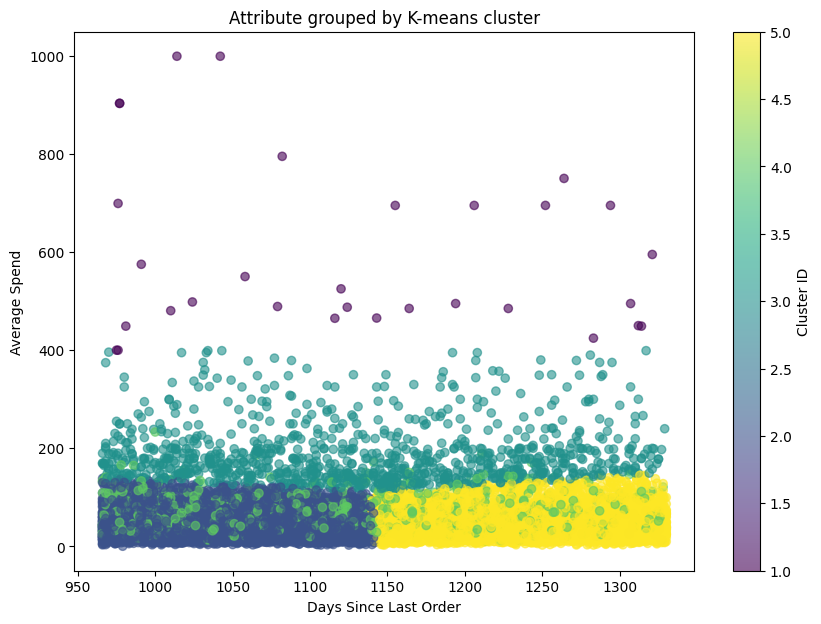

In [7]:
# prompt: 1. Using predictions_df, and matplotlib, generate a scatterplot. 2. On the x-axis of the scatterplot, display days_since_last_order and on the y-axis, display average_spend from predictions_df. 3. Color by cluster. 4. The chart should be titled "Attribute grouped by K-means cluster."

import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    predictions_df["days_since_last_order"],
    predictions_df["average_spend"],
    c=predictions_df["CENTROID_ID"],  # Color by cluster
    cmap="viridis",  # Colormap for clusters
    alpha=0.6,
)

# Add labels and title
plt.xlabel("Days Since Last Order")
plt.ylabel("Average Spend")
plt.title("Attribute grouped by K-means cluster")

# Add a colorbar to show cluster IDs
plt.colorbar(scatter, label="Cluster ID")

# Show the plot
plt.show()

In [8]:
query = """
SELECT
 CONCAT('cluster ', CAST(centroid_id as STRING)) as centroid,
 average_spend,
 count_orders,
 days_since_last_order
FROM (
 SELECT centroid_id, feature, ROUND(numerical_value, 2) as value
 FROM ML.CENTROIDS(MODEL `{0}.{1}`)
)
PIVOT (
 SUM(value)
 FOR feature IN ('average_spend',  'count_orders', 'days_since_last_order')
)
ORDER BY centroid_id
""".format(dataset_name, model_name)

df_centroid = client.query(query).to_dataframe()
df_centroid.head()

,centroid,average_spend,count_orders,days_since_last_order
0,cluster 1,609.06,1.14,1122.45
1,cluster 2,45.17,1.29,1048.54
2,cluster 3,191.81,1.18,1131.65
3,cluster 4,58.22,3.68,1102.89
4,cluster 5,46.58,1.27,1233.01


In [9]:
df_query = client.query(query).to_dataframe()
df_query.to_string(header=False, index=False)

cluster_info = []
for i, row in df_query.iterrows():
 cluster_info.append("{0}, average spend ${2}, count of orders per person {1}, days since last order {3}"
  .format(row["centroid"], row["count_orders"], row["average_spend"], row["days_since_last_order"]) )

cluster_info = (str.join("\n", cluster_info))
print(cluster_info)

cluster 1, average spend $609.06, count of orders per person 1.14, days since last order 1122.45
cluster 2, average spend $45.17, count of orders per person 1.29, days since last order 1048.54
cluster 3, average spend $191.81, count of orders per person 1.18, days since last order 1131.65
cluster 4, average spend $58.22, count of orders per person 3.68, days since last order 1102.89
cluster 5, average spend $46.58, count of orders per person 1.27, days since last order 1233.01


In [10]:
model = GenerativeModel("gemini-2.0-flash-001")

prompt = f"""
You're a creative brand strategist, given the following clusters, come up with \
creative brand persona, a catchy title, and next marketing action, \
explained step by step. Identify the cluster number, the title of the person, a persona for them and the next marketing step.

Clusters:
{cluster_info}

For each Cluster:
* Title:
* Persona:
* Next marketing step:
"""

responses = model.generate_content(
   prompt,
   generation_config={
      "temperature": 0.1,
      "max_output_tokens": 800,
      "top_p": 1.0,
      "top_k": 40,
   }
)

print(responses.text)

/usr/local/lib/python3.11/dist-packages/vertexai/generative_models/_generative_models.py:433: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


Okay, here's a breakdown of each cluster, with a creative title, persona, and next marketing action, designed to re-engage and potentially upgrade these customers:

**Cluster 1: The "High-Value Hibernators"**

*   **Title:** The "Re-Ignite" Campaign

*   **Persona:** **"Luxury Larry"**

    *   **Description:** Larry is a discerning customer who made a significant purchase in the past. He appreciates quality and is willing to spend for it. He likely has a busy lifestyle and may have simply forgotten about the brand or found a temporary alternative. He values exclusivity and personalized experiences.
    *   **Demographics:** Likely 35-55, higher income, values quality and convenience.
    *   **Motivations:** Reminded of the brand's value, offered a compelling reason to return, feels appreciated as a high-value customer.
    *   **Pain Points:** Overwhelmed with choices, easily forgets brands, needs a strong incentive to switch back.

*   **Next Marketing Step:** **Personalized "Welcom